# Импорты

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
import os
print(os.getcwd())

In [ ]:
print(os.getcwd())
# Путь к данным
data_dir = os.path.join(os.getcwd(), 'dataset_mil_civ')

# Печать содержимого папки dataset
print("Содержимое dataset:", os.listdir(data_dir))

# Проверка наличия папок train, test, validation
for sub_dir in ['train', 'test', 'validation']:
    path = os.path.join(data_dir, sub_dir)
    print(f"Папка {sub_dir} существует:", os.path.exists(path))
    print(f"Содержимое {sub_dir}:", os.listdir(path) if os.path.exists(path) else "Не существует")


In [14]:
img_height, img_width = 256, 256

In [ ]:
import matplotlib.pyplot as plt

# Пути к данным
data_dir = os.path.join(os.getcwd(), 'dataset_mil_civ');

# Загрузка данных
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    label_mode='binary',
    labels='inferred'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    label_mode='binary',
    labels='inferred'
)

Found 20122 files belonging to 2 classes.
Found 7015 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Оценка сбалансированности 

Количество изображений в каждом классе:
civilian: 9210 изображений (45.77%)
military: 10912 изображений (54.23%)


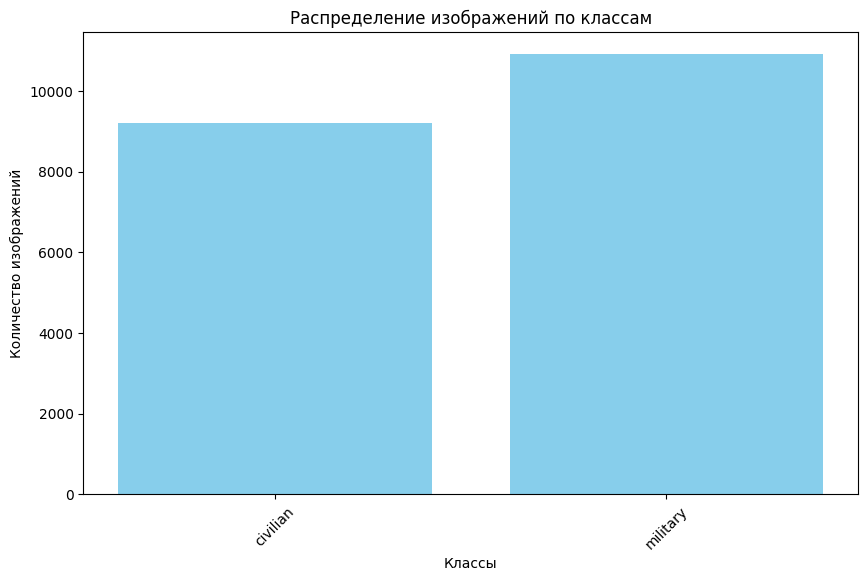


Среднее количество изображений на класс: 10061.00
Стандартное отклонение количества изображений по классам: 851.00
Датасет достаточно сбалансирован.


In [21]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Укажите путь к основной папке с датасетом
train_data_dir = os.path.join(data_dir, 'train');

# Считаем количество изображений в каждом классе
class_counts = Counter()
for class_name in os.listdir(train_data_dir):
    class_dir = os.path.join(train_data_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len([img for img in os.listdir(class_dir) if img.endswith(('jpg', 'jpeg', 'png'))])
        class_counts[class_name] = num_images

# Выводим количество изображений в каждом классе
total_images = sum(class_counts.values())
print("Количество изображений в каждом классе:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} изображений ({(count / total_images) * 100:.2f}%)")

# Построим диаграмму для наглядного отображения
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Классы")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.xticks(rotation=45)
plt.show()

# Оценка сбалансированности: вычислим стандартное отклонение
mean_count = total_images / len(class_counts)
std_dev = (sum((count - mean_count) ** 2 for count in class_counts.values()) / len(class_counts)) ** 0.5
print(f"\nСреднее количество изображений на класс: {mean_count:.2f}")
print(f"Стандартное отклонение количества изображений по классам: {std_dev:.2f}")

# Интерпретация результата
if std_dev < 0.1 * mean_count:
    print("Датасет достаточно сбалансирован.")
else:
    print("Датасет несбалансирован — стоит рассмотреть технику балансировки, например, аугментацию данных.")


In [ ]:
import pandas as pd
dataset_unbatched = tuple(test_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)
count = labels.value_counts()
print(counts)

In [ ]:
print(count)

Визуализация

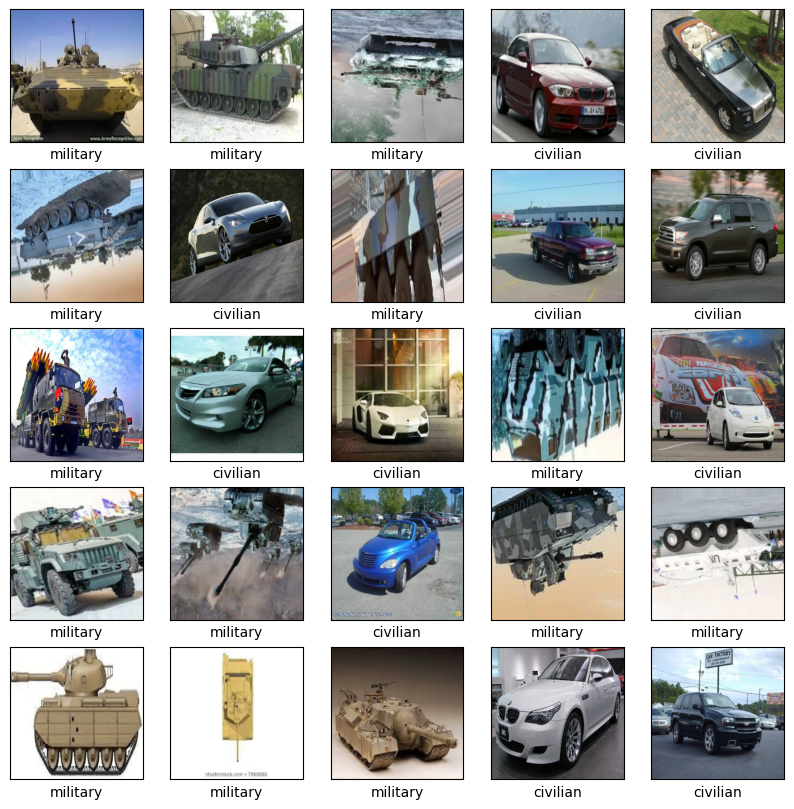

In [9]:
# Определение классов 
class_names = ['civilian', 'military']

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):  # Берем один пакет данных
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.xlabel(class_names[int(labels[i])])
plt.show()


Создание модели     

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers, Input

num_classes = len(class_names)

model =  Sequential([
Input(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  Dropout(0.2),  # Dropout перед полносвязным слоем
  layers.Dense(1, activation='sigmoid')
])

Компиляция модели

In [ ]:
model.compile(
    optimizer='adam',              # Оптимизатор, может быть 'adam', 'sgd', и т.д.
    loss='binary_crossentropy',  # Функция потерь для многоклассовой классификации
    metrics=['accuracy']          # Метрика для оценки точности
)

Обучение модели

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
epochs = 10

history = model.fit(
    train_ds,                      # Тренировочный датасет
    epochs,                     # Количество эпох
    validation_data=test_ds,       # Тестовый датасет для оценки модели на каждой эпохе
    batch_size=32,                 # Размер батча
    callbacks=[early_stopping]
)


Оценка модели

In [11]:
model = tf.keras.models.load_model(r'models/model_civ_mil.keras')


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

629/629 ━━━━━━━━━━━━━━━━━━━━ 128s 203ms/step
629/629 ━━━━━━━━━━━━━━━━━━━━ 133s 211ms/step - accuracy: 0.9915 - loss: 0.0231
Test accuracy: 0.9910048842430115


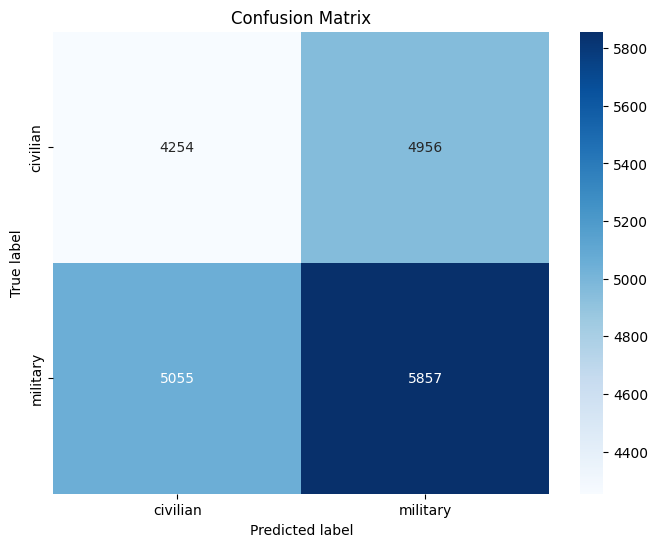

In [19]:
# Получаем предсказания
y_pred = model.predict(train_ds)
y_pred = (y_pred > 0.5).astype("int")  # Преобразуем вероятности в метки

# Реальные метки
y_true = []
for images, labels in train_ds:
    y_true.extend(labels.numpy())

# Оценка точности
test_loss, test_acc = model.evaluate(train_ds)
print(f"Test accuracy: {test_acc}")

# Построение confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
for i, (image, label) in enumerate(zip(test_ds.unbatch().take(25), y_pred[:25])):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image[0].numpy().astype("uint8"))  # Берем только саму картинку
    plt.title("military" if label == 1 else "civilian")
    plt.axis("off")
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np

# Инициализация счетчиков классов
class_counts = [0, 0]  # для бинарной классификации, 2 класса: "civilian" и "military"

# Перебор всех данных в тестовом наборе
for images, labels in test_ds:
    labels = tf.cast(labels, tf.int32)  # Преобразуем метки в int32, если они в другом формате
    class_counts += np.bincount(labels.numpy(), minlength=2)

print(f"Class distribution in test dataset: civilian = {class_counts[0]}, military = {class_counts[1]}")


In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Параметры изображения и количество для вывода
img_height, img_width = 256, 256  # Укажите разрешение, с которым работает модель
batch_size = 32

# Предсказания на дополнительном тестовом датасете
predictions = model.predict(train_ds)




629/629 ━━━━━━━━━━━━━━━━━━━━ 148s 235ms/step


In [20]:
# Вывод метрик
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["civilian", "military"]))


Accuracy: 0.502484842460988
              precision    recall  f1-score   support

    civilian       0.46      0.46      0.46      9210
    military       0.54      0.54      0.54     10912

    accuracy                           0.50     20122
   macro avg       0.50      0.50      0.50     20122
weighted avg       0.50      0.50      0.50     20122



In [ ]:
model.save('models/model_civ_mil.keras')